# Installation

Install all the dependencies to make the most out of TorchCAM

In [1]:
!pip install torchvision matplotlib

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple


## Latest stable release

In [2]:
!pip install torchcam

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple


## From source

In [3]:
# Install the most up-to-date version from GitHub
!pip install -e git+https://github.com/frgfm/torch-cam.git#egg=torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining torchcam from git+https://github.com/frgfm/torch-cam.git#egg=torchcam
  Cloning https://github.com/frgfm/torch-cam.git to ./src/torchcam
  Running command git clone -q https://github.com/frgfm/torch-cam.git /content/src/torchcam
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: torchcam
    Found existing installation: torchcam 0.3.2
    Uninstalling torchcam-0.3.2:
      Successfully uninstalled torchcam-0.3.2
  Running setup.py develop for torchcam


Now go to `Runtime/Restart runtime` for your changes to take effect!

# Basic usage

In [7]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [2]:
# Download an image
!wget https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
# Set this to your image path if you wish to run it on your own data
img_path = "border-collie.jpg"

--2022-11-17 22:23:00--  https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
Resolving www.woopets.fr (www.woopets.fr)... 104.26.13.50, 172.67.73.8, 104.26.12.50, ...
Connecting to www.woopets.fr (www.woopets.fr)|104.26.13.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273044 (267K) [image/jpeg]
Saving to: ‘border-collie.jpg.1’

border-collie.jpg.1   4%[                    ]  12.38K  --.-KB/s               ^C


In [8]:
# Instantiate your model here
model = resnet18(pretrained=True).eval()

In [9]:
import argparse

parse = argparse.ArgumentParser()
parse.add_argument('--dataset_path', type=str, default='../StealingVerification-main/data/cifar10/',
                   help="dataset path")
parse.add_argument('--dataset', type=str, default='CIFAR10', choices=['CIFAR10', 'self'], help="dataset的名称")
parse.add_argument('--mode', type=str, default='teacher', help="训练方式（暂时不要修改）")
parse.add_argument('--model_id', type=str, default='0', help="模型名称，关系到保存地址")
parse.add_argument('--batch_size', type=int, default=128)
parse.add_argument('--epoch', type=int, default=135)
parse.add_argument('--device', type=str, default='cuda')
parse.add_argument('--learning_rate', type=float, default=0.01)
parse.add_argument('--save_path', type=str, default='./model_train/', help="保存的大路径")
parse.add_argument('--model_root', type=str, default='', help="模型地址")
parse.add_argument('--num_classes', type=int, default=10)
parse.add_argument('--normalize', type=int, default=1)
args = parse.parse_args(args=['--dataset_path', '../StealingVerification-main/data/cifar10_seurat_10%/',
                              '--dataset', 'CIFAR10',
                              '--mode', 'teacher',
                              '--model_id', 'test',
                              '--batch_size', '128',
                              '--epoch', '100',
                              '--device', 'cuda',
                              '--learning_rate', '0.1',
                              '--save_path', './trained/',
                              '--model_root', '../dataset-inference-main/models/CIFAR10/model_standard_teacher_normalized',
                              '--num_classes', '10',
                              '--normalize', '1'])

print(args)

Namespace(batch_size=128, dataset='CIFAR10', dataset_path='../StealingVerification-main/data/cifar10_seurat_10%/', device='cuda', epoch=100, learning_rate=0.1, mode='teacher', model_id='test', model_root='../dataset-inference-main/models/CIFAR10/model_standard_teacher_normalized', normalize=1, num_classes=10, save_path='./trained/')


In [10]:
import sys
sys.path.append('')
from funcs import get_student_teacher
student, _ = get_student_teacher(args)
location = f"../dataset-inference-main/models/CIFAR10/model_standard_teacher_normalized/final.pt"
student = student.to(args.device)
student.load_state_dict(torch.load(location, map_location = args.device))

ModuleNotFoundError: No module named 'funcs'

## Illustrate your classifier capabilities

In [12]:
cam_extractor = SmoothGradCAMpp(model)
# Get your input
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

NameError: name 'student' is not defined

In [8]:
# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)

torch.Size([1, 7, 7])


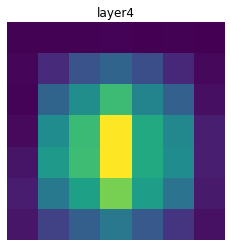

In [9]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.squeeze(0).numpy()); plt.axis('off'); plt.title(name); plt.show()

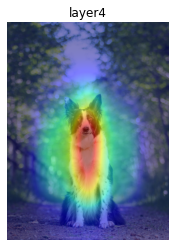

In [10]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [11]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

# Advanced tricks

## Extract localization cues

In [12]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
print(softmax(out, dim=1).max())

tensor(0.9115, grad_fn=<MaxBackward1>)


In [13]:
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

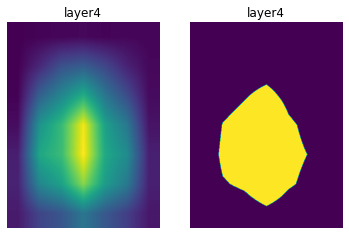

In [14]:
# Resize it
resized_cams = [resize(to_pil_image(cam.squeeze(0)), img.shape[-2:]) for cam in cams]
segmaps = [to_pil_image((resize(cam, img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# Plot it
for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
  _, axes = plt.subplots(1, 2)
  axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
  axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
  plt.show()

In [15]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

## Fuse CAMs from multiple layers

In [16]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model, ["layer2", "layer3", "layer4"])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [17]:
# This time, there are several CAMs
for cam in cams:
  print(cam.shape)

torch.Size([1, 28, 28])
torch.Size([1, 14, 14])
torch.Size([1, 7, 7])


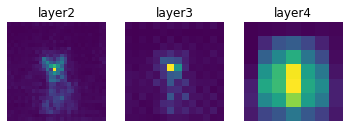

In [18]:
# The raw CAM
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.squeeze(0).numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

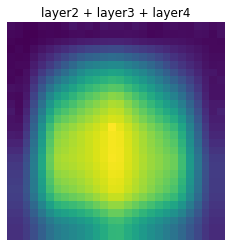

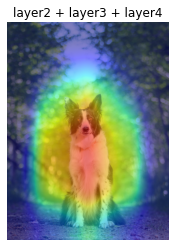

In [19]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.squeeze(0).numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

In [20]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()